# Inverse Probability Weighting and Doubly Robust Estimation

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo

* Inverse Probability Weighting (IPW)
  * Aplicação no Python
* Doubly Robust Estimation
  * Aplicação no Python




**Observações:** O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer *feedback* ou sugestão de melhoria.

---

### Inverse Probability Weighting

O *Inverse Probability Weighting* (IPW) é uma técnica de ponderação da amostra por probabilidades inversas. A ideia central é reponderar cada unidade amostral de acordo com o inverso da probabilidade de estar no grupo em que ela efetivamente foi observada.

Esse procedimento cria uma população ponderada (ou pseudo-população) na qual a atribuição do tratamento é independente das covariáveis observadas $X$. Em outras palavras, após a reponderação, os grupos tratados e não tratados tornam-se comparáveis, como se tivessem sido alocados aleatoriamente.

Na literatura também é comum encontrarmos o termo ***Inverse Probability of Treatment Weighting - IPTW***. É a mesma coisa que IPW, mas o nome enfatiza que a probabilidade usada é a de receber o tratamento (*treatment*).

Em termos práticos, esse método apresenta uma vantagem clara sobre o PSM:
* Lembre que o PSM descarta unidades ao realizar o pareamento, já o IPW aproveita todas as unidades ao reponderá-las.
* Ou seja, enquanto o PSM constrói comparabilidade excluindo observações (matching), o IPW constrói comparabilidade reponderando toda a amostra.

Entretanto, pode apresentar um ponto negativo:
* Se a probabilidade de ser tratado $P(D=1|X)$ for muito próximo de 0 ou 1, os pesos explodem, gerando instabilidade, e a necessidade de "trimming" ou uso de métodos mais robustos.
  * O trimming consiste em descartar observações com probabilidades muito próximas de 0 ou 1, para evitar que algumas unidades dominem a estimativa.
  * O trimming é uma forma de garantir a hipótese de positividade ou overlap: todos devem ter uma chance positiva de serem tratados ou não tratados.

**Observação:** o ***Propensity Score Weighting - PSW*** é um caso particular de IPW, quando os pesos são construídos a partir do escore de propensão (*propensity score*). Como o ***escore de propensão*** é justamente a probabilidade de tratamento condicional às covariáveis, então o PSW é um subtipo de IPTW/IPW.

***Definições***

O **Propensity Score** é definido como a probabilidade condicional de uma unidade receber o tratamento dado o vetor de covariáveis observadas:

$$
p(X_i) = \Pr(D_i = 1 \mid X_i)
$$

onde:  
- $D_i \in \{0, 1\}$ é o indicador de tratamento;  
- $X_i$ é o vetor de covariáveis observadas.  

No IPW, cada unidade é reponderada de acordo com um peso ($w_{i}$):

$$
w_i =
\begin{cases}
\frac{1}{p(X_i)}, & \text{se } D_i = 1 \\
\frac{1}{1 - p(X_i)}, & \text{se } D_i = 0
\end{cases}
$$

Como dissemos, nosso objetivo é criar uma população *pseudo-randomizada*, em que a distribuição das covariáveis seja balanceada entre tratados e não tratados. Diferentemente do *Propensity Score Matching (PSM)*, que emparelha unidades tratadas e não tratadas com base no escore de propensão, o IPW utiliza ***todos os dados disponíveis***, atribuindo pesos às unidades com base em sua probabilidade condicional de tratamento $p(X_i)$.

Repare que:

* Se a unidade é tratada ($D_i=1$):
  * O peso é $1/p(X_i)$.
  * Se $p(X_i)$ for alto (ex.: 0.9), então $1/p(X_i) \approx 1.11$ → peso pequeno.
  * Se $p(X_i)$ for baixo (ex.: 0.1), então $1/p(X_i) = 10$ → peso grande.
  * Ou seja: tratados improváveis de serem tratados recebem mais peso.

* Se a unidade é não tratada ($D_i=0$):
  * O peso é $1/(1 - p(X_i))$.
  * Se $p(X_i)$ for alto (ex.: 0.9), então $1/(1 - p(X_i)) = 10$ → peso grande.
  * Se $p(X_i)$ for baixo (ex.: 0.1), então $1/(1 - p(X_i)) \approx 1.11$ → peso pequeno.
  * Ou seja: não tratados improváveis de serem não tratados recebem mais peso.

O IPW “corrige” a amostra para que grupos que estavam sub-representados fiquem mais visíveis na pseudo-população.
* Um indivíduo que estava em um grupo quase certo (um tratado com $p(X)\approx 1$ ou um controle com $p(X)\approx 0$) ganha peso baixo, porque ele já era muito esperado estar lá.
* Já um indivíduo que parecia estar “no grupo errado” (um tratado com $p(X)$ baixo ou um controle com $p(X)$ alto) ganha peso alto, porque ele ajuda a corrigir o desbalanceamento da amostra.

Esse mecanismo faz com que, após a ponderação:
* A distribuição de $X$ entre tratados e controles fique semelhante.
* A amostra ponderada represente uma situação como se o tratamento tivesse sido atribuído aleatoriamente.

**Resumindo o problema**

Vamos relembrar o problema de identificação numa representação DAG.

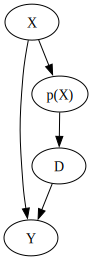

In [71]:
# Importando o pacote
import graphviz as gr

# Gráfico indicando as variáveis e suas relações
g = gr.Digraph()
g.edge("D", "Y")
g.edge("p(X)", "D")
g.edge("X", "Y")
g.edge("X", "p(X)")
g

Em dados observacionais, o tratamento não é aleatório. Por exemplo: indivíduos com alto nível de escolaridade podem ter alta probabilidade de adotar um tratamento (vacina, tecnologia etc.). Se compararmos diretamente tratados vs. não tratados, podemos confundir efeito do tratamento com efeito de características $X$ (viés de seleção).

O IPW cria uma pseudo-população em que a probabilidade de tratamento é a mesma para todas as unidades (como se fosse sorteio). Para isso, ele reequilibra os grupos dando mais peso às observações improváveis:
* Tratados improváveis (baixa chance de ter sido tratados) são valiosos, porque são raros exemplos de tratados em regiões onde normalmente só há controles.
* Controles improváveis (baixa chance de ter sido controles) são valiosos, porque são raros exemplos de controles em regiões onde normalmente só há tratados.


Essas observações “improváveis” são justamente as que ajudam a garantir sobreposição:

* Imagine que em certo nível de $X$ quase todos são tratados.
  * Se aparece um controle improvável ali, ele ajuda a mostrar “como seria o resultado sem tratamento” nesse mesmo nível de $X$.
* Imagine que em outro nível de $X$ quase todos são controles.
  * Se aparece um tratado improvável ali, ele ajuda a mostrar “como seria o resultado com tratamento” nesse mesmo nível de $X$.

Relembre, graficamente:

<div style="text-align:center;">
    <img src="images\suportecomum.png"  alt="Imagem" style="width: 500px;"/>
</div>

### Hipóteses de Identificação

Em termos de hipóteses para identificação do tratamento, seguimos com as 3 hipóteses anteriores dos modelos de matching.


1. **Independência condicional** (*unconfoundedness*, *ignorability*, ou *selection on observables*): 

$$ (Y^{1}, Y^{0}) \perp D | P(D=1|X) $$

ou 

$$ (Y^{1}, Y^{0}) \perp D | p(X) $$


2. **Suporte Comum** (sobreposição, *common support*):	
$$ 0  < Pr(D=1|X)  <  1 $$

ou 

$$ 0  < p(X)  <  1 $$

3. **Valor de Tratamento Unitário Estável (SUTVA - Stable Unit Treatment Value Assumption):**

$$ Y_i(\mathbf{D}) = Y_i(D_i) $$

* **Não interferência entre unidades:** o resultado de uma unidade $i$ depende apenas de seu próprio tratamento, não do tratamento das demais.  
* **Tratamento único e bem definido:** não existem diferentes versões do mesmo tratamento que possam levar a resultados distintos.


### Calculando o ATE, ATT e ATU com IPW


Agora vamos definir os pesos para os diferentes efeitos de tratamento que queremos estimar.

* ATE (Average Treatment Effect)
* ATT (Average Treatment Effect on the Treated)
* ATU (Average Treatment Effect on the Untreated)

**IPW Não-Normalizado (Puro)** 

Também conhecida como **Horvitz–Thompson - HT** (não normalizadas): pode ter variância maior, mas é o estimador “puro”. O peso **IPTW para o ATE** é definido como:

$$
w_i^{ATE} = \frac{D_i}{p(X_i)} + \frac{1 - D_i}{1 - p(X_i)}
$$

- Tratados ($D_i = 1$) recebem peso $1 / p(X_i)$  
- Não-Tratados ($D_i = 0$) recebem peso $1 / (1 - p(X_i))$

O peso **IPTW para o ATT** é definido como:

$$
w_i^{ATT} = D_i + (1 - D_i) \cdot \frac{p(X_i)}{1 - p(X_i)}
$$

- Tratados ($D_i = 1$) recebem peso = 1  
- Não-Tratados ($D_i = 0$) recebem peso $p(X_i) / (1 - p(X_i))$


O peso **IPTW para o ATU** é definido como:

$$
w_i^{ATU} = (1 - D_i) + D_i \cdot \frac{1 - p(X_i)}{p(X_i)}
$$

- Tratados ($D_i = 1$) recebem peso $\frac{1 - p(X_i)}{p(X_i)}$
- Não-Tratados ($D_i = 0$) recebem peso = 1


***Interpretação dos pesos***

- **No ATE**: cria pseudo-população onde todos têm chance de ser tratados ou não tratados → comparação simétrica.
  - Unidades tratadas com baixa probabilidade de tratamento recebem peso alto.  
  - Unidades não tratadas com baixa probabilidade de não tratamento recebem peso alto.  

- **No ATT**: foca nos tratados, reponderando os controles para “parecerem tratados”.
  - Tratados sempre têm peso 1.  
  - Não tratadas são reponderados para se assemelhar à distribuição de covariáveis dos tratados.

- **No ATU**: ATU: foca nos não tratados, reponderando os tratados para “parecerem não tratados”.
  - Tratados são reponderados para se assemelhar à distribuição de covariáveis dos não tratados.
  - Não-tratados sempre têm peso 1.


### Aplicação em Python

Vamos aplicar passo a passo a ponderação por IPW (HT).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

In [5]:
# DataFrame
df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/cattaneo2.dta")

In [6]:
# Criar a variável de resultado
df['Y'] = df['bweight']

# Crie a variável 'Treated' com valor inicial de 0
df['Treated'] = 0
# Recodifique 'Treated' para 1 se 'mbsmoke' for igual a 'smoker'
df.loc[df['mbsmoke'] == 'smoker', 'Treated'] = 1

df['casada'] = 0
df.loc[df['mmarried']=='married', 'casada'] = 1

# gerar uma variável de contagem de linhas iniciando em 1
df['id'] = np.arange(len(df)) + 1

# Conjunto de Covariáveis X
X = ['casada', 'mage', 'medu']

Rodar o escore de propensão com um logit, e salvar no dataframe $p(X)$ (vamos chamar a variável de "pscore"):

In [8]:
# Estimar o escore de propensão com regressão logística
df['pscore'] = smf.logit("Treated ~ casada + mage + medu + fage + fedu + nprenatal", data=df).fit().predict()

Optimization terminated successfully.
         Current function value: 0.444219
         Iterations 6


In [9]:
df[['Y', 'Treated', 'pscore']]

,Y,Treated,pscore
0,3459,0,0.099858
1,3260,0,0.458399
2,3572,0,0.206358
3,2948,0,0.145825
4,2410,0,0.117996
...,...,...,...
4637,3317,1,0.280531
4638,3030,1,0.150491
4639,2950,0,0.255109
4640,3969,0,0.133592


Repare que as probabilidades dos não tratados é baixa. Entretanto, há alguns com probabilidade de ser tratado maiores que outros. Vejamos a distribuição das probabilidades entre os grupos:

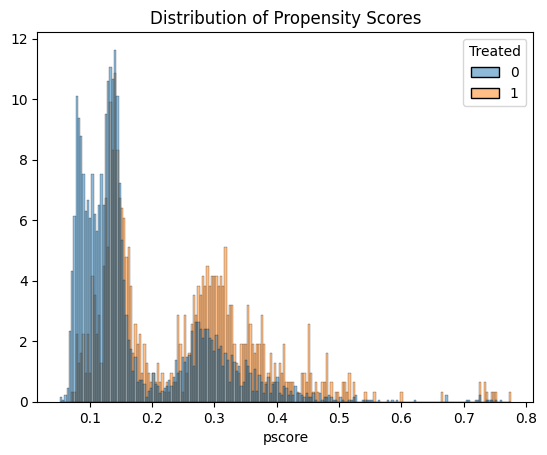

In [11]:
# Verificar graficamente a área de sobreposição
sns.histplot(data=df, x='pscore', hue='Treated', bins=200, stat='density', common_norm=False).\
    set(ylabel="", title="Distribution of Propensity Scores");

Criar os pesos ATE:

In [12]:
# ATE weights
df['W_ATE_T'] = df['Treated'] / df['pscore']
df['W_ATE_C'] = (1 - df['Treated']) / (1 - df['pscore'])

In [13]:
df[['Y', 'Treated', 'pscore', 'W_ATE_T', 'W_ATE_C']]

,Y,Treated,pscore,W_ATE_T,W_ATE_C
0,3459,0,0.099858,0.000000,1.110936
1,3260,0,0.458399,0.000000,1.846377
2,3572,0,0.206358,0.000000,1.260014
3,2948,0,0.145825,0.000000,1.170720
4,2410,0,0.117996,0.000000,1.133782
...,...,...,...,...,...
4637,3317,1,0.280531,3.564674,0.000000
4638,3030,1,0.150491,6.644932,0.000000
4639,2950,0,0.255109,0.000000,1.342478
4640,3969,0,0.133592,0.000000,1.154191


In [14]:
df['Y_psw_ATE'] = df['Y'] * df['W_ATE_T'] - df['Y'] * df['W_ATE_C']

In [15]:
df[['Y', 'Treated', 'pscore', 'W_ATE_T', 'W_ATE_C', 'Y_psw_ATE']]

,Y,Treated,pscore,W_ATE_T,W_ATE_C,Y_psw_ATE
0,3459,0,0.099858,0.000000,1.110936,-3842.727703
1,3260,0,0.458399,0.000000,1.846377,-6019.189806
2,3572,0,0.206358,0.000000,1.260014,-4500.770983
3,2948,0,0.145825,0.000000,1.170720,-3451.282124
4,2410,0,0.117996,0.000000,1.133782,-2732.414892
...,...,...,...,...,...,...
4637,3317,1,0.280531,3.564674,0.000000,11824.022325
4638,3030,1,0.150491,6.644932,0.000000,20134.144440
4639,2950,0,0.255109,0.000000,1.342478,-3960.311042
4640,3969,0,0.133592,0.000000,1.154191,-4580.984566


In [16]:
df['Y_psw_ATE'].mean()

np.float64(-379.6361195596848)

***ATT psw***

In [17]:
# ATT weights
df['W_ATT_T'] = df['Treated'] * 1 
df['W_ATT_C'] = (1 - df['Treated']) * (df['pscore'] / (1 - df['pscore']))

In [18]:
df[['Y', 'Treated', 'pscore', 'W_ATT_T', 'W_ATT_C']]

,Y,Treated,pscore,W_ATT_T,W_ATT_C
0,3459,0,0.099858,0,0.110936
1,3260,0,0.458399,0,0.846377
2,3572,0,0.206358,0,0.260014
3,2948,0,0.145825,0,0.170720
4,2410,0,0.117996,0,0.133782
...,...,...,...,...,...
4637,3317,1,0.280531,1,0.000000
4638,3030,1,0.150491,1,0.000000
4639,2950,0,0.255109,0,0.342478
4640,3969,0,0.133592,0,0.154191


In [19]:
df['Y_psw_ATT'] = df['Y'] * df['W_ATT_T'] - df['Y'] * df['W_ATT_C']

In [20]:
df['Y_psw_ATT'].mean()

np.float64(-53.78603561792295)

***ATU psw***

In [21]:
# ATU weights
df['W_ATU_T'] = df['Treated'] * (1 - df['pscore']) / df['pscore']
df['W_ATU_C'] = (1 - df['Treated']) * 1

In [22]:
df[['Y', 'Treated', 'pscore', 'W_ATU_T', 'W_ATU_C']]

,Y,Treated,pscore,W_ATU_T,W_ATU_C
0,3459,0,0.099858,0.000000,1
1,3260,0,0.458399,0.000000,1
2,3572,0,0.206358,0.000000,1
3,2948,0,0.145825,0.000000,1
4,2410,0,0.117996,0.000000,1
...,...,...,...,...,...
4637,3317,1,0.280531,2.564674,0
4638,3030,1,0.150491,5.644932,0
4639,2950,0,0.255109,0.000000,1
4640,3969,0,0.133592,0.000000,1


In [23]:
df['Y_psw_ATU'] = df['Y'] * df['W_ATU_T'] - df['Y'] * df['W_ATU_C']

In [24]:
df['Y_psw_ATU'].mean()

np.float64(-325.85008394176185)

**IPW Normalizado**

Outra forma de calcular os pesos é utilizando a normalização dos pesos de IPW para garantir que a soma dos pesos seja igual a 1. Isso é feito dividindo cada peso pela soma total dos pesos. Isso também ajuda a reduzir a variância dos estimadores ponderados. É conhecido como a ***forma de Hájek para o IPW***.

No IPW “puro”, os pesos podem somar mais que o tamanho da amostra, o que dificulta a interpretação.

Para corrigir, define-se uma versão normalizada dos pesos:

$$ w_{i}^{norm} = \frac{w_{i}}{ \frac{1}{n} \sum_{j=1}^{n} w_{j}} $$

onde:
* peso bruto (Horvitz–Thompson) da unidade $w_{i}$
* Soma de todos os pesos da amostra $\sum_{j=1}^{n} w_{j}$
* Média dos pesos da amostra $\frac{1}{n} \sum_{j=1}^{n} w_{j}$

Ou seja, você divide cada peso pela média dos pesos.

* Isso garante que a média dos pesos dê 1, e a soma dos pesos dê n.
* Preserva a representatividade da amostra.
* Mas não corta nenhuma observação.
* Serve para melhorar a interpretação e reduzir um pouco a variabilidade, mas não resolve o problema de pesos extremos.




In [25]:
df['Y_psw_ATE_normalized'] = (df['Y'] * df['W_ATE_T'] / df['W_ATE_T'].sum()) - (df['Y'] * df['W_ATE_C'] / df['W_ATE_C'].sum())

In [26]:
df[['Y', 'Treated', 'pscore', 'Y_psw_ATE_normalized']]

,Y,Treated,pscore,Y_psw_ATE_normalized
0,3459,0,0.099858,-0.823875
1,3260,0,0.458399,-1.290505
2,3572,0,0.206358,-0.964958
3,2948,0,0.145825,-0.739950
4,2410,0,0.117996,-0.585826
...,...,...,...,...
4637,3317,1,0.280531,2.661741
4638,3030,1,0.150491,4.532458
4639,2950,0,0.255109,-0.849085
4640,3969,0,0.133592,-0.982156


Para recuperar o efeito quando utilizamos os pesos normalizados somamos as contribuições individuais.

In [27]:
df['Y_psw_ATE_normalized'].sum()

np.float64(-226.83537586140227)

***ATT normalizado***

In [28]:
df['Y_psw_ATT_normalized'] = (df['Y'] * df['W_ATT_T'] / df['W_ATT_T'].sum()) - (df['Y'] * df['W_ATT_C'] / df['W_ATT_C'].sum())

In [29]:
df['Y_psw_ATT_normalized'].sum()

np.float64(-203.0880429295332)

***ATU normalizado***


In [30]:
df['Y_psw_ATU_normalized'] = (df['Y'] * df['W_ATU_T'] / df['W_ATU_T'].sum()) - (df['Y'] * df['W_ATU_C'] / df['W_ATU_C'].sum())

In [31]:
df['Y_psw_ATU_normalized'].sum()

np.float64(-232.16673508353304)

Repare que os resultados são diferentes mesmo possuindo o mesmo alvo (ATE, ATT, ATU). Isso ocorre, porque:

* Horvitz–Thompson (HT) é não-normalizado, pode ter mais variância, mas é não-viesado sob overlap.
* Hájek é normalizado, tende a ser mais estável em amostras finitas, mas pode ter um viés pequeno.

Por isso o número pode mudar bastante — principalmente se você tiver pesos extremos (como você já viu: alguns > 10). O Hájek “reescala” as contribuições, o que pode puxar o efeito para outro valor.

### Aplicando no Python

Para realizar a aplicação direta da ponderação por IPW, com efeito médio do tratamento e seus intervalos de confiança, podemos utilizar a biblioteca `statsmodels` para ajustar um modelo de regressão ponderada.


Aqui calculamos os pesos para os indivíduos tratados e não tratados em uma variável no dataframe.

In [32]:
# ATE weights no python
df['W_ATE_ols'] = df['Treated'] / df['pscore'] + (1 - df['Treated']) / (1 - df['pscore'])

Depois rodamos a regressão para encontrar o ATE:

In [33]:
# Aplicando regressão ponderada (IPTW) para ATE
model_ate = smf.wls("Y ~ Treated", data=df, weights=df['W_ATE_ols']).fit()
print(model_ate.summary())

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.038
Model:                            WLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     183.3
Date:                qui, 02 out 2025   Prob (F-statistic):           5.38e-41
Time:                        11:05:47   Log-Likelihood:                -36579.
No. Observations:                4642   AIC:                         7.316e+04
Df Residuals:                    4640   BIC:                         7.318e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3399.2003     11.701    290.515      0.0

Repare que uma propriedade importante do WLS (Weighted Least Squares), é que ele já faz a normalização implícita (ele força as médias ponderadas a se alinharem com os pesos), mesmo que nós tenhamos indicado pesos diferentes (não normalizados).

Para o ATT:

In [34]:
# ATT weights
df['W_ATT_ols'] = df['Treated'] * 1  + (1 - df['Treated']) * (df['pscore'] / (1 - df['pscore']))

In [35]:
# Aplicando regressão ponderada (IPTW) para ATT
model_att = smf.wls("Y ~ Treated", data=df, weights=df['W_ATT_ols']).fit()
print(model_att.summary())

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.029
Model:                            WLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     140.1
Date:                qui, 02 out 2025   Prob (F-statistic):           7.15e-32
Time:                        11:06:39   Log-Likelihood:                -37105.
No. Observations:                4642   AIC:                         7.421e+04
Df Residuals:                    4640   BIC:                         7.423e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3340.7478     12.054    277.146      0.0

ATT com peso IPTW normalizado é -213.3092

Para o ATU

In [36]:
df['W_ATU_ols'] = df['Treated'] * (1 - df['pscore']) / df['pscore'] + (1 - df['Treated']) * 1

In [37]:
# Aplicando regressão ponderada (IPTW) para ATU
model_atu = smf.wls("Y ~ Treated", data=df, weights=df['W_ATU_ols']).fit()
print(model_atu.summary())

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.040
Model:                            WLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     194.7
Date:                qui, 02 out 2025   Prob (F-statistic):           2.21e-43
Time:                        11:08:53   Log-Likelihood:                -36556.
No. Observations:                4642   AIC:                         7.312e+04
Df Residuals:                    4640   BIC:                         7.313e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3412.9116     11.604    294.121      0.0

***em suma***

* O IPW resolve viés de seleção **SE o modelo de propensity score estiver bem especificado**. Porque se o modelo $p(X)$ estiver errado o estimador permanece enviesado.
* O IPW também pode sofrer com variância alta (mesmo com normalização).



**Relação entre IPW e OR/RA**

Em aulas anteriores, vimos que o Outcome Regression (OR, ou Regression Adjustment - RA) é outra forma de estimar os efeitos causais via regressão de resultados potenciais. 

$$ m_{d}(X) = E[Y∣D=d,X]$$

$$ d \in \{0,1 \}$$

onde modelávamos $m_{0}(X)$ e $m_{1}(X)$ para imputarmos os contrafactuais.

Tanto IPW quanto OR/RA possuem as mesmas **hipóteses de identificação**:

1. Ignorabilidade condicional (Unconfoundedness): garante que, dado X, o tratamento é “como aleatório”.
2. Positividade (Overlap / Suporte Comum): garante que, para cada valor de $X$, existe chance positiva de observar tanto tratados quanto controles.
3. SUTVA

***Onde está a diferença, então?***

IPW:
* Identificação vem de reponderar as unidades.
* ***Precisa estimar corretamente o propensity score $p(X)$.***
* Sensível a erros no modelo de $p(X)$ e a pesos extremos.
* O IPW ajusta via pesos, mas pode sofrer de instabilidade e PS misspecification.

OR/RA:
* Identificação vem de modelar os potenciais resultados $m_{d}(X)=E[Y∣D=d,X]$.
* ***Precisa especificar corretamente o modelo da regressão de resultados***.
* Sensível a erros de especificação funcional.
* O OR ajusta diretamente o $Y$, mas pode sofrer de model misspecification.


***E se juntássemos os dois?***

* O OR é consistente se o modelo do resultado estiver correto (mesmo que $p(X)$ esteja errado).
* O IPW é consistente se o modelo do propensity score estiver correto (mesmo que $m_{d}(X)$ esteja errado).
* Se um dos dois estiver certo, ainda temos consistência.
* Se ambos estiverem corretos temos ganho de eficiência.

OBS: Consistência aqui significa que, com amostras grandes, o estimador converge para o efeito causal verdadeiro, mesmo que o outro modelo esteja mal especificado.

Esse é o princípio da Dupla Robustez (Double Robustness). O DR faz um ajuste duplo, e só precisa que um dos dois modelos esteja correto.

O IPW cuida do viés de seleção via pesos; o OR cuida via ajuste de regressão. O DR combina os dois para se proteger contra a má especificação de um dos modelos.


## Doubly Robust Estimation (DR - AIPW)

***Doubly Robust Estimation (DR)***

* É a ideia geral de combinar Outcome Regression (Regression Adjustment) e Inverse Probability Weighting. 
* Um estimador é “duplamente robusto” quando é consistente se pelo menos um dos modelos (de resultado ou de propensão) estiver corretamente especificado. 
  * Exemplo clássico: *Augmented Inverse Probability Weighting - AIPW*.


***AIPW (Augmented Inverse Probability Weighting)***

Na avaliação de efeitos causais, dois métodos são comuns:  

- **Outcome Regression (OR):** modelar diretamente o resultado condicional a $X$ e $D$.  
- **Inverse Probability Weighting (IPW):** reponderar as observações pelo escore de propensão $\hat{p}(X)$.  
- Lembre que cada um dos estimadores é **consistente apenas se o modelo estiver corretamente especificado**.  

O **estimador duplamente robusto (Doubly Robust, ou Augmented IPW - AIPW)** combina as duas abordagens, garantindo consistência se **pelo menos um dos modelos estiver correto**.

**Componentes básicos**

- Tratamento: $D_i \in \{0,1\}$
- Covariáveis: $X_i$
- Resultado: $Y_i = D_i Y_i(1) + (1-D_i) Y_i(0)$
- Propensity score: $p(X) = P(D=1|X)$
- Funções de regressão: $\mu_d(X) = E[Y|D=d,X]$

Queremos o efeito médio do tratamento (ATE):

$$
\beta_{ATE} = E[Y(1) - Y(0)] 
$$


#### Outcome Regression (OR)

O estimador para o ATE é:

$$
\hat{\beta}^{OR}_{ATE} = \frac{1}{n}\sum_{i=1}^n \left[ \hat{\mu}_1(X_i) - \hat{\mu}_0(X_i) \right]
$$

onde $\hat{\mu}_d(X)$ pode ser obtido por regressão (em casos mais sofisticados, pode ser modelado de outras formas).


#### Inverse Probability Weighting (IPW)

O estimador ATE via IPW é:

$$
\hat{\beta}^{IPW}_{ATE} = \frac{1}{n}\sum_{i=1}^n \left( \frac{D_i Y_i}{\hat{p}(X_i)} - \frac{(1-D_i)Y_i}{1-\hat{p}(X_i)} \right)
$$


## Estimador Doubly Robust (AIPW)


Vamos derivar a ideia passo a passo:


* **ATE** é

$$ \beta_{ATE} = \mathbb{E}[Y(1) - Y(0)] $$

* Outcome Regression (OR), se tivermos $mu_d(X) = \mathbb{E}[Y|D=d,X]$, então:

$$ \beta_{ATE} = \mathbb{E}[\mu_1(X) - \mu_0(X)] $$

* Estimador amostral:

$$ \hat\beta^{OR}_{ATE} = \frac{1}{n}\sum_{i=1}^n \big(\hat\mu_1(X_i) - \hat\mu_0(X_i)\big) $$

Mas isso depende de especificar corretamente ($\mu_d(X)$).


* IPW:

$$ \mathbb{E}[Y(1)] = \mathbb{E}\left[\frac{D Y}{p(X)}\right], \quad \mathbb{E}[Y(0)] = \mathbb{E}\left[\frac{(1-D)Y}{1-p(X)}\right] $$

Portanto:

$$ \beta_{ATE} = \mathbb{E}\left[\frac{D Y}{p(X)} - \frac{(1-D)Y}{1-p(X)}\right] $$

* Estimador amostral:

$$ \hat\beta^{IPW}_{ATE} = \frac{1}{n}\sum_{i=1}^n \left( \frac{D_i Y_i}{\hat p(X_i)} - \frac{(1-D_i)Y_i}{1-\hat p(X_i)} \right) $$

Mas isso depende de especificar corretamente ($p(X)$).


***Ideia central do AIPW***

* Começar pelo estimador de regressão ($\hat\mu_1 - \hat\mu_0$).
* Corrigir seus erros adicionando um termo baseado em resíduos reponderados pelo IPW.


$$ \text{AIPW} = \text{OR} + \text{correção com resíduos (IPW)} $$


O estimador DR/AIPW pode ser escrito como:

$$
\hat{\beta}^{DR}_{ATE} = \frac{1}{n}\sum_{i=1}^n 
\left\{ 
   \big(\hat{\mu}_1(X_i) - \hat{\mu}_0(X_i)\big) 
   + \frac{D_i}{\hat p(X_i)} \big(Y_i - \hat\mu_1(X_i)\big) 
   - \frac{1-D_i}{1-\hat p(X_i)} \big(Y_i - \hat\mu_0(X_i)\big)
\right\}
$$

Observe cada parte:

1. **$\hat\mu_1(X_i) - \hat\mu_0(X_i)$** é o ajuste via regressão (OR).
2. **$\frac{D_i}{\hat p(X_i)}(Y_i - \hat\mu_1(X_i))$** corrige a parte tratada se a regressão estiver errada.
3. **$- \frac{1-D_i}{1-\hat p(X_i)}(Y_i - \hat\mu_0(X_i))$** corrige a parte de controle se a regressão estiver errada.




**Interpretação:**  

- O **primeiro termo** ($\hat{\mu}_1 - \hat{\mu}_0$) é a predição média da regressão de resultados (*Outcome Regression*).  
- Os **termos adicionais** são “correções” baseadas em resíduos ponderados por IPW.  


***Propriedade de Dupla Robustez***

- Se $\hat{\mu}_d(X)$ estiver corretamente especificado → os resíduos têm média zero, e o estimador DR converge para o ATE mesmo que $\hat{p}(X)$ esteja errado.  
- Se $\hat{p}(X)$ estiver corretamente especificado → a ponderação corrige vieses da regressão mal especificada, garantindo consistência.  
- Se **ambos** estiverem corretos → o estimador é **eficiente** (atinge menor variância assintótica).


***Em termos intuitivos:***

- O DR é uma **regressão de resultados com resíduos reponderados**, de modo que o viés de especificação de um modelo é compensado pelo outro.  


**Extensões**

- **ATT (Average Treatment Effect on the Treated):** versão análoga existe, na subamostra e com pesos ajustados para focar nos tratados.
- **ATU (Average Treatment Effect on the Untreated):** versão análoga existe, na subamostra e com pesos ajustados para focar nos não tratados.


**Por que a o estimador Duplamente Robusto (*Augmented Inverse Probability Weighting* - AIPW) é tão atraente?**

A razão é que só precisamos de uma das duas previsões, *$\hat{\mu}$* ou *$\hat{p}$*, para que a estimativa seja correta (não enviesada/imparcial). 
* Se ambos os modelos estiverem corretos, o estimador será mais eficiente do que qualquer um dos modelos sozinho. 
* Se um dos modelos estiver errado, o estimador ainda será consistente, desde que o outro modelo esteja correto. 

Isso é uma grande vantagem em relação a outras abordagens, como a regressão de resultados ou a ponderação pelo escore de propensão, que exigem que ambos os modelos estejam corretos para que o estimador seja consistente.

Suponha que $\hat{\mu}$ esteja especificado corretamente. Então $E[\hat{\mu}^{d}(x)=E[Y|X=x, D=d]$ , então o estimador DR é consistente, mesmo que o modelo de propensão $\hat{p}$ esteja mal especificado.

$$ \hat{\beta^{DR}} =  \mathbb{E} \left[ (\mu_1(X) - \mu_0 (X)) +  \frac{D}{\hat{p}(X)}.(Y_{1} - \mu_1 (X)) - \frac{(1-D)}{1-\hat{p}(X)}.(Y_{0} - \mu_0 (X)) \right] = $$

$$  =  \mathbb{E} \left[ (\mu_1(X) - \mu_0 (X)) \right] = $$

$$  =  \mathbb{E} \left[ Y^{1} - Y^{0} \right] = $$

$$ = \beta $$

A intuição é que, se $\hat{\mu}$ está **especificado corretamente é não-viesado e o fator de ajuste desaparece**, uma vez que os resíduos convergem para zero.


Por outro lado, suponha $\hat{p}$ está especificado corretamente, ou seja, $E[\hat{p}(X)]=P(D=1|X)$, então o estimador DR é consistente, mesmo que o modelo de resultados $\hat{\mu}$ esteja mal especificado.

$$ \hat{\beta^{DR}} =  \mathbb{E} \left[ (\mu_1(X) - \mu_0 (X)) +  \frac{D}{\hat{p}(X)}.(Y_{1} - \mu_1 (X)) - \frac{(1-D)}{1-\hat{p}(X)}.(Y_{0} - \mu_0 (X)) \right] = $$

$$ \mathbb{E} \left[ \mu_1(X) - \mu_0 (X) + \frac{D}{\hat{p}(X)}.Y_{1} - \frac{D}{\hat{p}(X)}.\mu_1 (X) - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} + \frac{(1-D)}{1-\hat{p}(X)}.\mu_0 (X) \right] = $$


$$ \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.Y_{1} - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} + \mu_1(X) - \frac{D}{\hat{p}(X)}.\mu_1 (X) + \frac{(1-D)}{1-\hat{p}(X)}.\mu_0 (X) - \mu_0 (X) \right] = $$


$$ \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.Y_{1} - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} + \mu_1(X) (1 - \frac{D}{\hat{p}(X)}) + \mu_0 (X)(\frac{(1-D)}{1-\hat{p}(X)} - 1) \right] = $$

$$ \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.Y_{1} - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} + \mu_1(X) (\frac{\hat{p}(X) - D}{\hat{p}(X)}) + \mu_0 (X)(\frac{(1-D)- (1-\hat{p}(X))}{1-\hat{p}(X)}) \right] = $$

$$ \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.Y_{1} - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} \right] = $$

$$ \mathbb{E} \left[ Y^{1} - Y^{0} \right] = $$

$$ = \beta $$

A intuição é que, se $\hat{p}$ está especificado corretamente, o $\hat{\beta}^{DR}$ é não viesado e o fator de ajuste desaparece, uma vez que os resíduos ($D_{i}-\hat{p}(X)$) convergem para zero.


## Aplicação em Python

Para facilitar a aplicação vamos utilizar uma abordagem moderna da biblioteca da Microsoft (EconML) chamada ***DR-Learner***.

Posteriormente vou trabalhar melhor os conceitos de CATE e Meta-Learners, mas por enquanto vamos focar na aplicação prática.


**Estimativa Duplamente Robusta**

Vamos fazer "na mão"

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [35]:
X_cols = ['casada', 'mage', 'medu', 'fage', 'fedu', 'nprenatal']   

# 1. Estimar propensity score
logit = LogisticRegression()
logit.fit(df[X_cols], df['Treated'])
df['ps'] = logit.predict_proba(df[X_cols])[:,1]

In [36]:
# 2. Estimar outcome regression separada por grupo
reg1 = LinearRegression().fit(df.loc[df.Treated==1, X_cols], df.loc[df.Treated==1, 'Y'])
reg0 = LinearRegression().fit(df.loc[df.Treated==0, X_cols], df.loc[df.Treated==0, 'Y'])

df['mu1'] = reg1.predict(df[X_cols])
df['mu0'] = reg0.predict(df[X_cols])

In [37]:
# 3. Construir o DR-ATE linha a linha
df['DR_ATE'] = (df['mu1'] - df['mu0'] 
                + df['Treated']/df['ps']*(df['Y'] - df['mu1'])
                - (1-df['Treated'])/(1-df['ps'])*(df['Y'] - df['mu0']))

In [38]:
# 4. Estimativa final
tau_dr = df['DR_ATE'].mean()
print("DR-ATE =", tau_dr)

DR-ATE = -225.5457375786401


In [39]:
# DR-ATT
DR_ATT = df['mu1'] - df['mu0'] + df["Treated"] * (df["Y"] - df['mu1']) - (1-df["Treated"])*df['ps'] / (1-df['ps']) * (df["Y"] - df['mu0'])
print("DR-ATT =", np.mean(DR_ATT))

DR-ATT = -228.03205775864893


In [40]:
# DR - ATU
DR_ATU = df['mu1'] - df['mu0'] + (1-df["Treated"]) * (df["Y"] - df['mu0']) - df['ps'] / (1-df['ps']) * (df["Y"] - df['mu1'])
print("DR-ATU =", np.mean(DR_ATU))

DR-ATU = -266.5862435302999


Esse tipo de estimador é bastante importante na literatura. E já possui alguns estimadores que realizam as estimações de forma direta. Por exemplo, poderíamos computar diretamente com 'LinearDRLearner' da biblioteca 'EconML' da Microsoft (EconML - Estimate causal effects with ML).

obs: https://www.microsoft.com/en-us/research/project/econml/

In [41]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from econml.dr import DRLearner
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression

c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\econml-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
X = df[['casada','mage','medu','fage','fedu','nprenatal']].values
Y = df['Y'].values
T = df['Treated'].values

In [43]:
dr = DRLearner(
    model_propensity=LogisticRegression(),
    model_regression=LinearRegression(),
    model_final=StatsModelsLinearRegression(),
    cv=5,
    random_state=45
)

dr.fit(Y=Y, T=T, X=X)

dr.ate_inference(X).summary().tables[0]

mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
-221.665,58.548,-3.786,0.0,-336.418,-106.912


O modelo nos dá diretamente o efeito médio do tratamento (ATE). A estimativa é estatisticamente diferente de zero e o intervalo de confiança inclui o valor verdadeiro que encontramos manualmente. Observe que obtivemos uma estimativa diferente porque a função **LinearDRLearner** também realizou o cross-fitting em segundo plano, o que não fizemos antes.

Outros pacotes importantes são 
* "causalml" (https://causalml.readthedocs.io/en/latest/about.html).
* "DoubleML" (https://doubleml.org/stable/).

## Boas práticas

* Verifique o balanço das covariáveis.
  * Tanto o IPW quanto o DR (AIPW) foram desenvolvidos para ambientes nos quais o tratamento não é atribuído aleatoriamente incondicionalmente, mas pode depender de algumas variáveis observáveis. Essas informações podem ser verificadas de duas maneiras: 
    * (1) Produza uma tabela de médias/equilíbrio das covariáveis. Se a randomização incondicional não for válida, esperamos ver diferenças significativas entre alguns observáveis; 
    * (2) Trace os escores de propensão estimados. Se a randomização incondicional for válida, esperamos que os escores de propensão sejam constantes.
* Verifique a suposição de sobreposição.
  * Podemos simplesmente verificar os limites dos escores de propensão previstos. Se a suposição de sobreposição for violada, acabamos dividindo algum termo do estimador por zero.